# View Graph For Indoor Navigation
## Abstract
Recently, several indoor graph models have been proposed to capture topological and geometric information, and generate navigation graphs and route descriptions. Varied modelling approaches in these studies lead to incompatible graph structures that are only suitable for specific use-cases. The inconsistency in the indoor models sources from the differences in modelling approaches that are either focused on capturing the <em>survey</em> or the <em>route</em> information. For example, the topological and geometric models capture survey information of an indoor environment, while navigation graph and route description models mainly store route information. In this study, we propose a new concept, based on <em>views</em>, to capture survey and route information of an indoor environment in a unified manner. We define views as directed line of sights in which the visible spatial objects and their relationships are the same along the view. Using views, moving in the space (route information) can be captured as going from one view to another, and survey information can be attached to each view based on its visibility situation.

## Hypothesis and Research Questions
This study hypothesizes that using the concept of <em>view</em> both survey and route knowledge of an indoor environment can be captured. To test the hypothesis, we will address the following research questions:
* How can views be extracted from geometric information (e.g., floor plans)?
* How can view graphs be constructed to capture <em>movement</em> and <em>turns</em> from one view to another?
* Can route descriptions and navigation graphs be generated from the view graph? By this way we can prove that route knowledge of an indoor environment can be captured by views.
* Can spatial relationships of indoor objects be extracted from the view graph? By this way we can prove that survey knowledge of an indoor environment can be captured by views.

## Definitions
* <b>Indoor Environment</b>: An indoor environment is conceptualized as a set of <em>containers</em> (i.e., navigable spaces) that are connected through <em>gateways</em>.
* <b>Container</b>: A container is a navigable space (e.g., a corridor or a room) that people can enter or exit using gateways. Containers may contain external landmarks that can be used for guidance purposes.
* <b>Gateway</b>: Gateways are either on the boundary of containers (connect a container to another), or inside the containers (i.e., decision points) where people can make a decision on how to move further inside the container.
* <b>Landmark</b>: Landmarks are external objects (people do not enter within them) that have significance for routing and guidance (e.g., signs).

## Method
1. Decomposing each container into visibility regions
2. Generating views:
    1. <b>inside a region</b>: If one or more gateways are inside the decomposed region a view is constructed from the region centroid to the gateway(s) and vice versa;
    2. <b>from a region to another region</b>: For adjacent regions, views are constructed to move from one region to its neighbours;
    3. <b>from a region to gateway(s)</b>: If a gateway is visible from a region (based on the region visibility signature, a view is constructed from the region centroid to its visible gateway(s);
3. Calculating spatial relationships for each view including topological, directional and order relationships that visible for the agent;
4. Decomposing region-to-gateway views to sequences of views if the visibility of gateways and landmarks changes across the views;
5. Generating a directed dual graph for views in which the nodes are views and edges are connection between views:
    * If the end of one view is the start another view, these views are connected through <em>movement</em>;
    * If the start of one view is the start of another view, these views are connected through <em>turn</em>
6. Linking the view graphs for containers based on the gateways that connects them to generate the view graph for the whole indoor environment -- i.e., views incident to gateways in one container will be linked to views that starts from the gateways in the other containers.

Finally, we demonstrate how the view graph can be used to (1) generate navigation graph, (2) extract spatial relationships, and (3) generate route descriptions.

## Environment
### Test Environment (Hypothetical Floor Plan)
![title](imgs_notebook/hypo_map.png)
<!-- ### Real World Environment (Melbourne Connect Level 5)
![title](imgs_notebook/mc_map.png) -->

## References
* Amoozandeh K, Winter S, Tomko M. Space decomposition based on visible objects in an indoor environment. Environment and Planning B: Urban Analytics and City Science. 2021 Aug 11:23998083211037347.
* Becker T, Nagel C, Kolbe TH. A multilayered space-event model for navigation in indoor spaces. In3D geo-information sciences 2009 (pp. 61-77). Springer, Berlin, Heidelberg.
* Liu L, Zlatanova S. A "door-to-door" path-finding approach for indoor navigation. Proceedings Gi4DM 2011: GeoInformation for Disaster Management, Antalya, Turkey, 3-8 May 2011. 2011.
* Mortari F, Zlatanova S, Liu L, Clementini E. Improved geometric network model (IGNM): A novel approach for deriving connectivity graphs for indoor navigation. ISPRS Annals of Photogrammetry, Remote Sensing & Spatial Information Sciences. 2014 Apr 23;2(4).
* Pang Y, Zhou L, Lin B, Lv G, Zhang C. Generation of navigation networks for corridor spaces based on indoor visibility map. International Journal of Geographical Information Science. 2020 Jan 2;34(1):177-201.
* Werner S, Krieg-Brückner B, Mallot HA, Schweizer K, Freksa C. Spatial cognition: The role of landmark, route, and survey knowledge in human and robot navigation. In Informatik’97 Informatik als Innovationsmotor 1997 (pp. 41-50). Springer, Berlin, Heidelberg.
* Yang L, Worboys M. Generation of navigation graphs for indoor space. International Journal of Geographical Information Science. 2015 Oct 3;29(10):1737-56.
* Zhou Z, Weibel R, Richter KF, Huang H. HiVG: A hierarchical indoor visibility-based graph for navigation guidance in multi-storey buildings. Computers, Environment and Urban Systems. 2022 Apr 1;93:101751.


## Creating View Graph

### Loading classes

In [1]:
# Parameters
from Parameters import Parameters

# Utitlies for mathematical calculation, isovist and visualization
from Isovist import Isovist
from Plotter import Plotter
from Utility import Utility

# Container -> Environment -> View Graph
from Container import Container
from Environment import IndoorEnvironment
from ViewGraph import ViewGraph

### Loading environment from GeoJSON files

In [2]:
Parameters.set_env("real")  # this can be set to "basic" environment, "hypo" environment as well
Parameters.print_info()

--------------------------------------
Real-world environment is active

Static Variables: 
	epsilon: 0.01
	precision: 2
	alpha: 40
	fov: 160
	min_area: 1000000
	max_area: 1000000
	door_weight: 50
	turn_weight: 0.05
--------------------------------------


In [3]:
def read_env():
    # Basic environment
    if Parameters.basic:
        address = 'envs/basic/'
        pfiles = ['t_bound.geojson']
        hfiles = [None]
        dfiles = ['t_doors.geojson']
        dpfiles = [None]
        lfiles = ['t_landmarks.geojson']
        # create an indoor environment
        ie = IndoorEnvironment(address, pfiles, hfiles, dfiles, dpfiles, lfiles)

    # Hypo environment
    elif Parameters.hypo:
        address = 'envs/hypo/'
        pfiles = ['hypo_env.geojson']
        hfiles = ['hypo_holes.geojson']
        dfiles = ['hypo_doors.geojson']
        dpfiles = ['hypo_dpoints.geojson']
        lfiles = ['hypo_landmarks.geojson']
        # create an indoor environment
        ie = IndoorEnvironment(address, pfiles, hfiles, dfiles, dpfiles, lfiles)

    # MC5 real world environment
    else:
        address = 'envs/mc-floor-5/'
        pfiles, hfiles, dfiles, dpfiles, lfiles = IndoorEnvironment.reformat(
            address, 'containers.geojson', 'doors.geojson', 'landmarks.geojson')
        # create an indoor environment
        ie = IndoorEnvironment('', pfiles, hfiles, dfiles, dpfiles, lfiles)
    return ie

ie = read_env()

environment files -- count is valid
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)


### Decomposing regions into isovists, and create view graph
Here, the following tasks are performed:
   * calculate isovists
   * decompose containers to regions
   * calculate visiblity signature for each region
   * create adjacency matrix
   * find initial views
   * decompose views
   * construct view graph
   * calculate spatial relationships
   * augment the actions in view graphs (to nodes and edges)


*******************************************
Analyzing: Emergency Stairs
Container environment is valid: True
region initial : 1


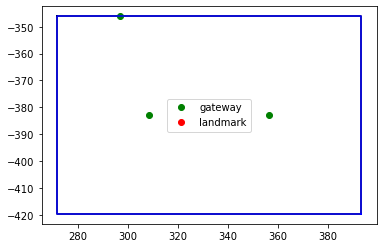

regions : 1 -- 1
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 12
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing: Women Toilet
Container environment is valid: True
region initial : 3


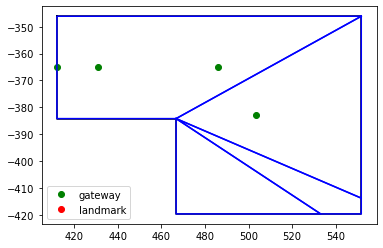

regions : 4 -- 3
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 49
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing: Disabled Toilet
Container environment is valid: True
region initial : 1


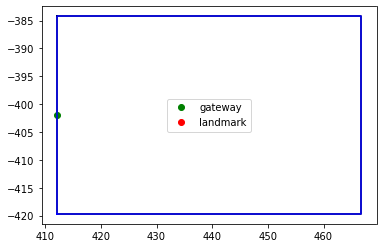

regions : 1 -- 1
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 2
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing: Men Toilet
Container environment is valid: True
region initial : 1


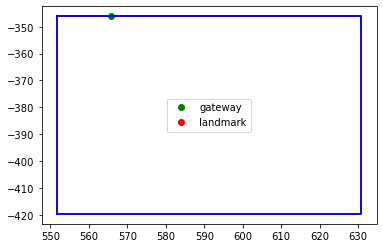

regions : 1 -- 1
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 2
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing: Corridor
Container environment is valid: True
region initial : 21


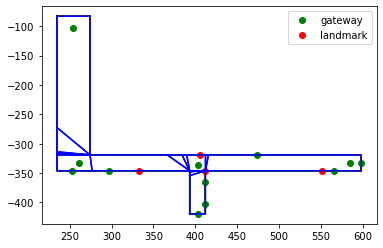

regions : 21 -- 21
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 319
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing: Active Hub
Container environment is valid: True
region initial : 43


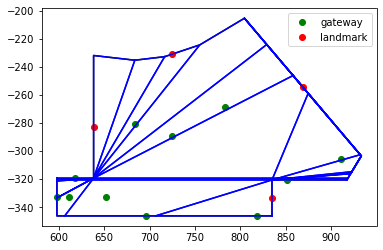

regions : 50 -- 43
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 537
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing: Stairs to Lower Floors
Container environment is valid: True
region initial : 1


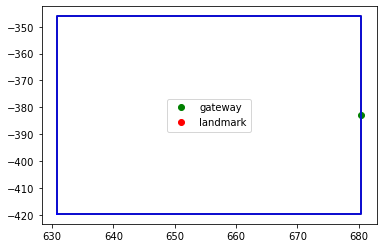

regions : 1 -- 1
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 2
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing: Ngi-a Djerring Gat-ith
Container environment is valid: True
region initial : 1


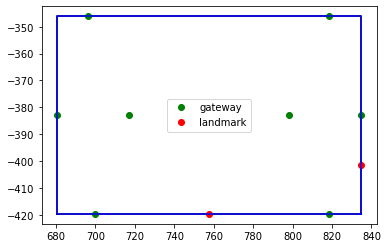

regions : 1 -- 1
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 72
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing: UX Lab
Container environment is valid: True
region initial : 16


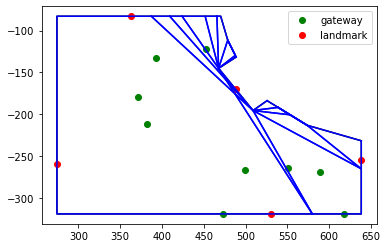

regions : 20 -- 16
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 211
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)


In [4]:
# create view graph
vgs, isovist_objects = ie.construct_view_graph()

In [6]:
ie.containers_names

['Emergency Stairs',
 'Women Toilet',
 'Disabled Toilet',
 'Men Toilet',
 'Corridor',
 'Active Hub',
 'Stairs to Lower Floors',
 'Ngi-a Djerring Gat-ith',
 'UX Lab']

## Shortest Path and Route Instruction
Here, we first generate a shortest path from a region to another. Then we use the augmented actions and relationships in view graph to generate route instructions from its results.

In [14]:
# todo: set parameters to Parameters class
start_container = 'Women Toilet'
start_region = 3
end_container = 'Active Hub'
end_region = 32

# todo: after setting this parameter in Parameters you can remove this if statement!
# if not Parameters.basic and not Parameters.hypo:
#     cidx = ie.containers_names.index(inital_container_name)
#     vg = vgs[cidx]
#     isovist_object = isovist_objects[cidx]
    
#     # todo: set parameters to Parameters class
#     start_region_shortest_path = 0
#     end_region_shortest_path = len(vg.regions_list) - 1

enter: Corridor
enter: Active Hub


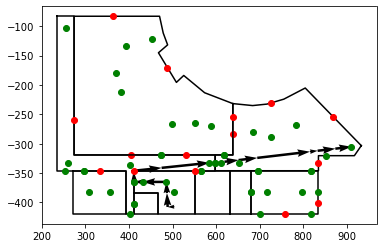

<Figure size 432x288 with 0 Axes>

In [15]:
# calculate shortest path and generate verbal description
vp, pv = ie.shortest_path(start_container, start_region, end_container, end_region)

# plot shortest path
plotter = Plotter()
for isovist_object in ie.isovist_objects:
    plotter.add_isovist(isovist_object)
plotter.add_views(pv)
plotter.show(False)
plotter.close()

In [16]:
# generate route instructions
def generate_route_descriptions(vp):
    container = ''
    container_vids = {}
    finals = {}
    for v in vp:
        info = v.split('-V')
        if container != info[0]:
            container = info[0]
            container_vids[container] = []
        container_vids[container].append(int(info[1]))
    print(container_vids)
    for container, vids in container_vids.items():
        cidx = ie.containers_names.index(container)
        vg = vgs[cidx]
        print(cidx)
        print(vids)
        rds = vg.generate_route_description(vids)
        finals[container] = rds
    return finals

def print_route_descriptions(rd_dictionary):
    containers = list(rd_dictionary.keys())
    for container in containers:
        rd = rd_dictionary[container]
        if containers.index(container) < len(containers) - 1:
            rd[len(rd)-1] = rd[len(rd)-1].replace('until you reach the destination', 'to enter {}'.format(containers[containers.index(container)+1]))
        for r in rd:
            print(r)
# vg.generate_route_description(vp)
generate_route_descriptions(vp)

{'Women Toilet': [108, 118, 119, 83, 84, 85], 'Corridor': [1116, 1117, 1140, 1153, 1182, 1183, 1184, 1185, 590, 591], 'Active Hub': [1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1546]}
1
[108, 118, 119, 83, 84, 85]
************Verbal Description**************
	Start with decision point 1 on your right
	move further and turn back in the first decision point and veer left
	Pass decision point 1 and move forward until you reach the destination
********************END*********************

4
[1116, 1117, 1140, 1153, 1182, 1183, 1184, 1185, 590, 591]
************Verbal Description**************
	Head towards the door to women toilet and turn left and veer left
	Pass the door to ux lab and move forward until you reach the destination
********************END*********************

5
[1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1546]
************Verbal Description**************
	Head towards the door to corridor
	Pass the landmark 3 and veer right and move forward until you r

{'Women Toilet': ['Start with decision point 1 on your right',
  'move further and turn back in the first decision point and veer left',
  'Pass decision point 1 and move forward until you reach the destination'],
 'Corridor': ['Head towards the door to women toilet and turn left and veer left',
  'Pass the door to ux lab and move forward until you reach the destination'],
 'Active Hub': ['Head towards the door to corridor',
  'Pass the landmark 3 and veer right and move forward until you reach the destination']}

## Derive Door-to-Door Visibility Graph


<b>Example:</b>
![title](imgs_notebook/door-to-door.png)
(source: Liu and Zlatanova, 2011)

<b>Node:</b>
* Doors (could be also gateways)

<b>Edge:</b>
* Direct visibility

<b>References:</b>
* Liu L, Zlatanova S. A "door-to-door" path-finding approach for indoor navigation. Proceedings Gi4DM 2011: GeoInformation for Disaster Management, Antalya, Turkey, 3-8 May 2011. 2011.
* Mortari F, Zlatanova S, Liu L, Clementini E. Improved geometric network model (IGNM): A novel approach for deriving connectivity graphs for indoor navigation. ISPRS Annals of Photogrammetry, Remote Sensing & Spatial Information Sciences. 2014 Apr 23;2(4).

### Generate door-to-door visibility graph (for doors and decision points)

generate door-to-door graph, only_doors False from view graph
Press Enter: Door to door visibility (doors+gateways)


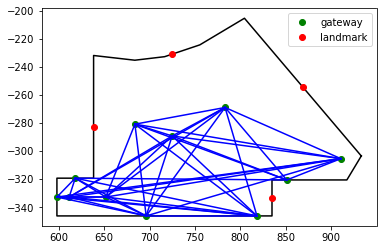

<Figure size 432x288 with 0 Axes>

In [16]:
# derive door-to-door visibility graph (doors and decision points)
connected, dtd_graph = vg.generate_door_to_door_graph(isovist_object)

print('Press Enter: Door to door visibility (doors+gateways)')
plotter = Plotter()
plotter.add_isovist(isovist_object)
plotter.add_points_lines(connected)
plotter.show()
plotter.close()
plotter.write_graph('d-t-d-all.html', dtd_graph, is_directed=False)

## Generate door-to-door visibility graph (only for doors)

generate door-to-door graph, only_doors True from view graph


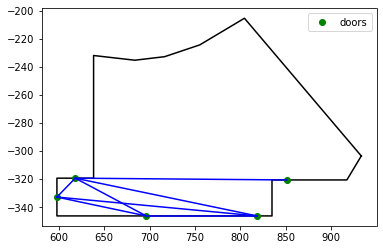

<Figure size 432x288 with 0 Axes>

In [17]:
# derive door-to-door visibility graph (only doors)
connected2, dtd_graph2 = vg.generate_door_to_door_graph(isovist_object, only_doors=True)
plotter = Plotter()
plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
plotter.add_points(isovist_object.door_points[:isovist_object.door_idx], 'doors')
plotter.add_points_lines(connected2)
plotter.show()
plotter.close()
plotter.write_graph('d-t-d-doors.html', dtd_graph2, is_directed=False)

## Derive navigation graph

<b>Example:</b>
![title](imgs_notebook/navigation-graph.png)
(source: Yang & Worboys, 2015)


<b>Reference</b>
* Yang L, Worboys M. Generation of navigation graphs for indoor space. International Journal of Geographical Information Science. 2015 Oct 3;29(10):1737-56.
* Pang Y, Zhou L, Lin B, Lv G, Zhang C. Generation of navigation networks for corridor spaces based on indoor visibility map. International Journal of Geographical Information Science. 2020 Jan 2;34(1):177-201.

derive navigation graph using spanning tree from viewgraph


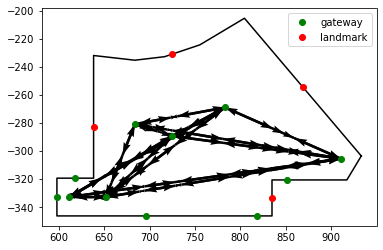

In [18]:
# derive all shortest path visibility graph and spanning tree
vps, pvs, st_vps, st_pvs, nvgraph = \
    vg.generate_navigation_graph(isovist_object, indirect_access=False)

plotter = Plotter()
plotter.add_isovist(isovist_object)

for pv in pvs:
    plotter.add_views(pv)
plotter.show()

<Figure size 432x288 with 0 Axes>

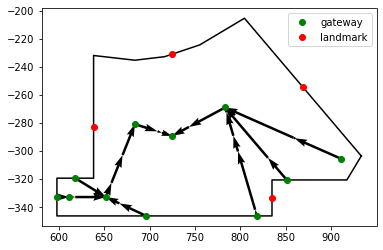

In [19]:
plotter.refresh()
for pv in st_pvs:
    plotter.add_views(pv)
plotter.show()

<Figure size 432x288 with 0 Axes>

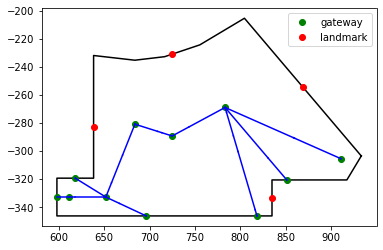

In [20]:
plotter.refresh()
for pv in st_pvs:
    plotter.add_points_lines(pv, is_vis=False)
plotter.show()

## Derive place graph from view graph

<b>Example:</b>

![title](imgs_notebook/placegraph.png)
(Source: Chen et. al. 2018)

Nodes:
* place:
* reference:
* n-plet:
* spatial relationship:


Edges:
* locatum:
* relatum:
* map:
* referred by:
* has reference direction:

<b>Reference</b>: Chen H, Vasardani M, Winter S, Tomko M. A graph database model for knowledge extracted from place descriptions. ISPRS International Journal of Geo-Information. 2018 Jun;7(6):221.


In [ ]:
# derive place graph
place_graph = vg.generate_place_graph(isovist_object)

In [ ]:
print('Press Enter: Place graph generation; visualize for all and only for landmark 2')
plotter.write_graph('placegraph.html', place_graph)

# Test Case for the Paper

In [3]:
Parameters.set_env('hypo')
Parameters.print_info()

--------------------------------------
Hypothetical environment is active

Static Variables: 
	epsilon: 1e-05
	precision: 5
	alpha: 40
	fov: 160
	min_area: 1000
	max_area: 1000
	door_weight: 0.5
	turn_weight: 0.0001
--------------------------------------


In [4]:
ie = read_env()

environment files -- count is valid
reading GeoJSON files (boundary, holes, doors and decision points)


Container environment is valid: True
region initial : 272


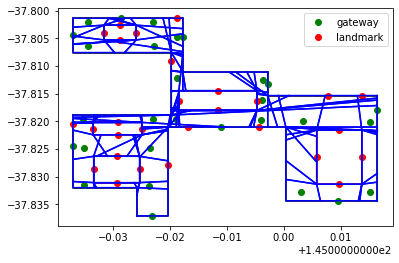

regions : 272 -- 272
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 3108
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)


In [5]:
# create view graph
vg, isovist_object = ie.cviewgraph(0)

<!-- ### Visualizing view graph -->

In [22]:
# vg_1549 = Utility.create_subgraph(vg.rviewgraph, 1549, 1)
# nt2 = Network(width='1000px', height='600px', directed=True, notebook=True)
# nt2.from_nx(vg_1549, show_edge_weights=False)
# nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
#                                     'spring_strength': 0.05, 'damping': 0.09})
# nt2.show('vg_1549.html')

## Generate Route Instructions

### Shortest path calculation in indoor environment

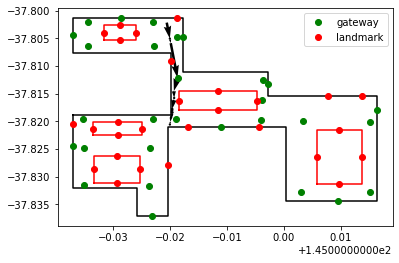

<Figure size 432x288 with 0 Axes>

In [6]:
# calculate shortest path
vp, pv= vg.shortest_path_regions(38, 56)
plotter = Plotter()
plotter.add_isovist(isovist_object)
plotter.add_views(pv)
plotter.show()
plotter.close()

### Generate route instructions

In [7]:
# generate verbal description
instructions = vg.generate_route_description(vp)

************Verbal Description**************
	Head towards decision point 4
	Follow decision point 4 on the front and turn right and turn left
	Pass the landmark 3 and turn back
	Follow decision point 7 on the left and veer left
	move further and veer right in the first decision point
	Follow decision point 16 on the front and move forward until you reach the destination
********************END*********************



## Derive Door-to-Door Visibility Graph


<b>Example:</b>
![title](imgs_notebook/door-to-door.png)
(source: Liu and Zlatanova, 2011)

<b>Node:</b>
* Doors (could be also gateways)

<b>Edge:</b>
* Direct visibility

<b>References:</b>
* Liu L, Zlatanova S. A "door-to-door" path-finding approach for indoor navigation. Proceedings Gi4DM 2011: GeoInformation for Disaster Management, Antalya, Turkey, 3-8 May 2011. 2011.
* Mortari F, Zlatanova S, Liu L, Clementini E. Improved geometric network model (IGNM): A novel approach for deriving connectivity graphs for indoor navigation. ISPRS Annals of Photogrammetry, Remote Sensing & Spatial Information Sciences. 2014 Apr 23;2(4).

### Generate door-to-door visibility graph (for doors and decision points)

generate door-to-door graph, only_doors False from view graph


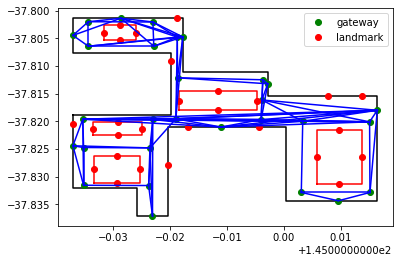

<Figure size 432x288 with 0 Axes>

In [7]:
# derive door-to-door visibility graph (doors and decision points)
connected, dtd_graph = vg.generate_door_to_door_graph(isovist_object)
plotter = Plotter()
plotter.add_isovist(isovist_object)
plotter.add_points_lines(connected)
plotter.show()
plotter.close()

In [8]:
from pyvis.network import Network

nt2 = Network(width='1000px', height='600px', directed=False, notebook=True)
nt2.from_nx(dtd_graph, show_edge_weights=False)
nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                    'spring_strength': 0.05, 'damping': 0.09})

nt2.show('d-t-d-all.html')

### Generate door-to-door visibility graph (only for doors)

generate door-to-door graph, only_doors True from view graph


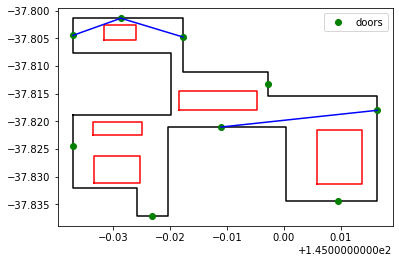

<Figure size 432x288 with 0 Axes>

In [9]:
connected2, dtd_graph2 = vg.generate_door_to_door_graph(isovist_object, only_doors=True)
plotter = Plotter()
plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
plotter.add_points(isovist_object.door_points[:isovist_object.door_idx], 'doors')
plotter.add_points_lines(connected2)
plotter.show()
plotter.close()

In [10]:
nt2 = Network(width='1000px', height='600px', directed=False, notebook=True)
nt2.from_nx(dtd_graph2, show_edge_weights=False)
nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                    'spring_strength': 0.05, 'damping': 0.09})

nt2.show('d-t-d-doors.html')

## Derive navigation graph

<b>Example:</b>
![title](imgs_notebook/navigation-graph.png)
(source: Yang & Worboys, 2015)


<b>Reference</b>
* Yang L, Worboys M. Generation of navigation graphs for indoor space. International Journal of Geographical Information Science. 2015 Oct 3;29(10):1737-56.
* Pang Y, Zhou L, Lin B, Lv G, Zhang C. Generation of navigation networks for corridor spaces based on indoor visibility map. International Journal of Geographical Information Science. 2020 Jan 2;34(1):177-201.

derive navigation graph using spanning tree from viewgraph


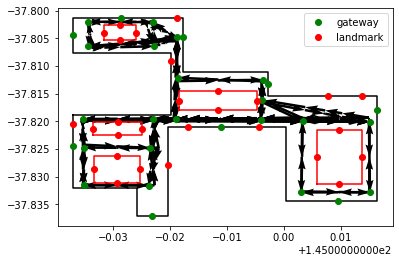

In [11]:
# derive all shortest path visibility graph and spanning tree
vps, pvs, st_vps, st_pvs, nvgraph = vg.generate_navigation_graph(isovist_object, False)
plotter = Plotter()
plotter.add_isovist(isovist_object)

# all path for gateways (doors+decision points)
for pv in pvs:
    plotter.add_views(pv)
plotter.show()

<Figure size 432x288 with 0 Axes>

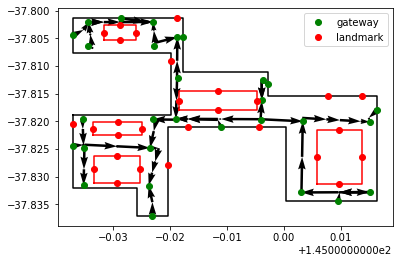

In [12]:
# minimum spanning tree of shortest path fully connect graph
plotter.refresh()
for pv in st_pvs:
    plotter.add_views(pv)
plotter.show()

<Figure size 432x288 with 0 Axes>

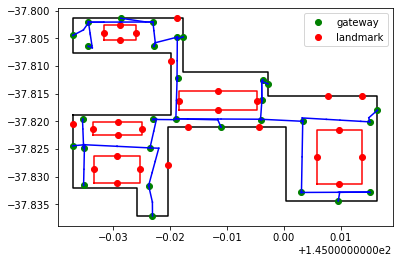

In [13]:
# navigation graph
plotter.refresh()
for pv in st_pvs:
    plotter.add_points_lines(pv, is_vis=False)
plotter.show()

In [14]:
# todo: generate navigation 'graph' for gateways + doors
nt2 = Network(width='1000px', height='600px', directed=False, notebook=True)
nt2.from_nx(nvgraph, show_edge_weights=False)
nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                    'spring_strength': 0.05, 'damping': 0.09})

nt2.show('nvgraph.html')

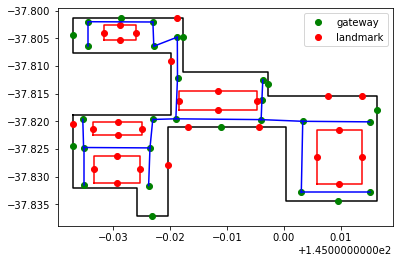

<Figure size 432x288 with 0 Axes>

In [15]:
# using points to visualize (not only view graph and shortest path)
# nvgraph.nodes[0]
lines = [[isovist_object.door_points[nvgraph.nodes[e[0]]['idx']], isovist_object.door_points[nvgraph.nodes[e[1]]['idx']]] for e in nvgraph.edges]
plotter = Plotter()
plotter.add_isovist(isovist_object)
plotter.add_points_lines(lines)
plotter.show()
plotter.close()

## Derive place graph from view graph

<b>Example:</b>

![title](imgs_notebook/placegraph.png)
(Source: Chen et. al. 2018)

Nodes:
* place:
* reference:
* n-plet:
* spatial relationship:


Edges:
* locatum:
* relatum:
* map:
* referred by:
* has reference direction:

<b>Reference</b>: Chen H, Vasardani M, Winter S, Tomko M. A graph database model for knowledge extracted from place descriptions. ISPRS International Journal of Geo-Information. 2018 Jun;7(6):221.


In [16]:
place_graph = vg.generate_place_graph(isovist_object)

derive place graph from view graph


### Single Nplet
Select a single n-plet from different spatial relationships and visualize the graph and spatial configuration

1. between
2. near
3. left/right

In [17]:
def nplet_extraction(nplet_id):
    ## nplet_id = 'n830'
    place_graph[nplet_id]  # left
    # place_graph['n100'] # between

    # nodes = ['n830', 'left', 'place12', 'gateway 12', 'landmark 20', 'gateway 1']
    nodes = [nplet_id]
    nodes.extend(list(dict(place_graph[nplet_id]).keys()))

    additional = []
    for node in nodes:
        if node.startswith('place'):
            additional.extend(list(dict(place_graph[node]).keys()))
    nodes.extend(additional)

    for v in list(place_graph.edges):
        if v[1] == nplet_id:
            nodes.append(v[0])
            if v[0].startswith('place'):
                nodes.extend(list(dict(place_graph[v[0]]).keys()))

    nplets = place_graph.subgraph(nodes)
    nt2 = Network(width='1000px', height='600px', directed=True, notebook=True)
    nt2.from_nx(nplets, show_edge_weights=False)
    nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                        'spring_strength': 0.05, 'damping': 0.09})
    return nt2, nodes

spatial_expression = 'gateway 8 between landmark 25 and landmark 23'
for n in place_graph.nodes:
    if n.startswith('n') and 'exp' in place_graph.nodes[n].keys() and place_graph.nodes[n]['exp'] == spatial_expression:
        nplet = n
        break
nt2, nplet_nodes = nplet_extraction(nplet)
nt2.show('nplet_1.html')


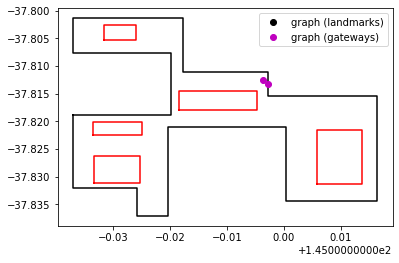

In [29]:
# plot spatial configuration for the n-plet
def plot_configuration(nodes):
    landmarks = []
    gateways = []
    for n in nodes:
        if 'gateway ' in n:
            gateways.append(isovist_object.door_points[int(n.replace('gateway ', ''))])
        elif 'landmark ' in n:
            landmarks.append(isovist_object.landmarks_points[int(n.replace('landmark ', ''))])

    plotter = Plotter()
    plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
    plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
    plotter.add_points(landmarks, label='graph (landmarks)', color='ko')
    plotter.add_points(gateways, label='graph (gateways)', color='mo')
    plotter.show()
plot_configuration(nplet_nodes)

In [30]:
spatial_expression = 'landmark 24 right of landmark 9'
for n in place_graph.nodes:
    if n.startswith('n') and 'exp' in place_graph.nodes[n].keys() and place_graph.nodes[n]['exp'] == spatial_expression:
        nplet = n
        break
nt2, nplet_nodes = nplet_extraction(nplet)
nt2.show('nplet_1.html')

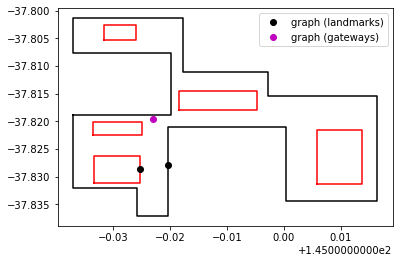

In [20]:
plot_configuration(nplet_nodes)

In [21]:
spatial_expression = 'gateway 7 near gateway 14'
for n in place_graph.nodes:
    if n.startswith('n') and 'exp' in place_graph.nodes[n].keys() and place_graph.nodes[n]['exp'] == spatial_expression:
        nplet = n
        break
nt2, nplet_nodes = nplet_extraction(nplet)
nt2.show('nplet_1.html')

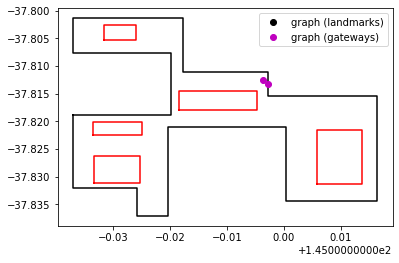

In [22]:
plot_configuration(nplet_nodes)

### Visualize a part of place graph (center: landmark 2, radius=2)

In [23]:
pg_l2_2 = Utility.create_subgraph(place_graph, 'landmark 2', 2)

nt2 = Network(width='1000px', height='600px', directed=True, notebook=True)
nt2.from_nx(pg_l2_2, show_edge_weights=False)
nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                    'spring_strength': 0.05, 'damping': 0.09})

nt2.show('placegraph_l2_2.html')

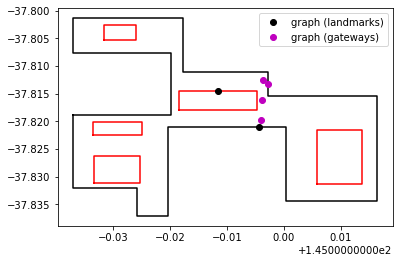

In [24]:
plotter = Plotter()
plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
ls = []
gs = []
for n in list(pg_l2_2.nodes):
    if 'landmark ' in n:
        lid = int(n.replace('landmark ', ''))
        ls.append(isovist_object.landmarks_points[lid])
    elif 'gateway ' in n:
        gid = int(n.replace('gateway ', ''))
        gs.append(isovist_object.door_points[gid])
plotter.add_points(ls, label='graph (landmarks)', color='ko')
plotter.add_points(gs, label='graph (gateways)', color='mo')
plotter.show()

### Visualize a part of place graph (center: gateway 7, radius=2)

In [25]:
pg_g7_2 = Utility.create_subgraph(place_graph, 'gateway 7', 2)

nt2 = Network(width='1000px', height='600px', directed=True, notebook=True)
nt2.from_nx(pg_g7_2, show_edge_weights=False)
nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                    'spring_strength': 0.05, 'damping': 0.09})

nt2.show('placegraph_g7_2.html')

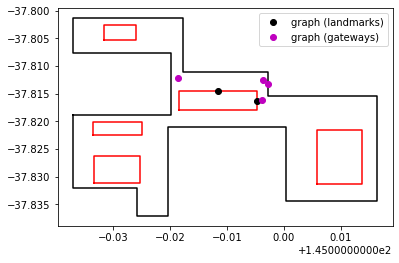

In [26]:
plotter = Plotter()
plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
ls = []
gs = []
for n in list(pg_g7_2.nodes):
    if 'landmark ' in n:
        lid = int(n.replace('landmark ', ''))
        ls.append(isovist_object.landmarks_points[lid])
    elif 'gateway ' in n:
        gid = int(n.replace('gateway ', ''))
        gs.append(isovist_object.door_points[gid])
plotter.add_points(ls, label='graph (landmarks)', color='ko')
plotter.add_points(gs, label='graph (gateways)', color='mo')
plotter.show()

## Just for testing

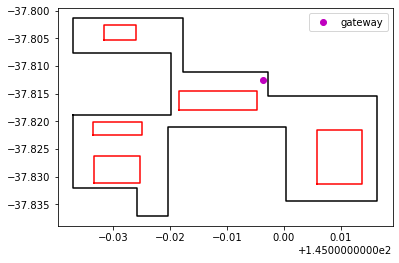

In [27]:
def plot_point(pid, ptype='landmark'):
    plotter = Plotter()
    plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
    plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
    if ptype != 'landmark':
        plotter.add_points([isovist_object.door_points[pid]], label=ptype, color='mo')
    else:
        plotter.add_points([isovist_object.landmarks_points[pid]], label=ptype, color='mo')
    plotter.show()
plot_point(14, 'gateway')

In [28]:
for n in place_graph.nodes:
    if n.startswith('gateway ') or n.startswith('landmark '):
        print('{0}: {1}'.format(n, len(place_graph[n])))

gateway 0: 8
gateway 1: 54
gateway 2: 58
gateway 3: 21
gateway 4: 53
gateway 5: 115
gateway 6: 6
gateway 7: 7
gateway 8: 207
gateway 9: 39
gateway 10: 32
gateway 11: 45
gateway 12: 49
gateway 13: 43
gateway 14: 26
gateway 15: 241
gateway 16: 230
gateway 17: 145
gateway 18: 52
gateway 19: 15
gateway 20: 32
gateway 21: 13
gateway 22: 207
gateway 23: 113
gateway 24: 197
gateway 25: 54
gateway 26: 28
gateway 27: 157
gateway 28: 71
landmark 0: 203
landmark 1: 160
landmark 2: 8
landmark 3: 56
landmark 4: 150
landmark 5: 44
landmark 6: 30
landmark 7: 163
landmark 8: 60
landmark 9: 36
landmark 10: 3
landmark 11: 25
landmark 12: 179
landmark 13: 39
landmark 14: 4
landmark 15: 22
landmark 16: 141
landmark 17: 40
landmark 18: 41
landmark 19: 52
landmark 20: 34
landmark 21: 18
landmark 22: 10
landmark 23: 258
landmark 24: 45
landmark 25: 201
landmark 26: 32
landmark 27: 88
